# HPCP Report Figures (Barebones)

_Date: 2025-10-16_

This notebook loads your benchmarking artifacts and renders the minimal plots for the report. All figures display inline—no files are saved.

## 1) Configure paths

In [1]:

import pathlib as pl
BASE = pl.Path.cwd()                               # or Path(__file__).resolve().parent for scripts
ROOT = (BASE.parent / "out_data").resolve()

SUMMARY_JSON = ROOT / "aggregate_sxs_summary.json"     # required for means/std (if available)
TIMINGS_CSV  = ROOT / "aggregate_timings.csv"          # per-run timings (optional but nice)
# Prefer aggregate arrays if you created them; else fall back to single-run arrays
ARR_MAIN     = ROOT / "run1/sxs_arrays.npz"
ARR_ALT1     = ROOT / "run2/sxs_arrays.npz"
ARR_ALT2     = ROOT / "run3/sxs_arrays.npz"

print("Summary JSON :", SUMMARY_JSON.exists(), SUMMARY_JSON)
print("Timings CSV  :", TIMINGS_CSV.exists(), TIMINGS_CSV)
print("Main arrays  :", ARR_MAIN.exists(), ARR_MAIN)
print("Alt1 arrays  :", ARR_ALT1.exists(), ARR_ALT1)
print("Alt2 arrays  :", ARR_ALT2.exists(), ARR_ALT2)


Summary JSON : True /home/hpcp44/demreg-hpcp-modul/python/out_data/aggregate_sxs_summary.json
Timings CSV  : True /home/hpcp44/demreg-hpcp-modul/python/out_data/aggregate_timings.csv
Main arrays  : True /home/hpcp44/demreg-hpcp-modul/python/out_data/run1/sxs_arrays.npz
Alt1 arrays  : True /home/hpcp44/demreg-hpcp-modul/python/out_data/run2/sxs_arrays.npz
Alt2 arrays  : True /home/hpcp44/demreg-hpcp-modul/python/out_data/run3/sxs_arrays.npz


## 2) Load artifacts

In [2]:

import json, numpy as np, csv

# Load summary json (means/std etc.) if present
summary = None
if SUMMARY_JSON.exists():
    summary = json.loads(SUMMARY_JSON.read_text())
    print("Loaded:", SUMMARY_JSON)

# Pick arrays file
arrays_path = None
if ARR_MAIN.exists():
    arrays_path = ARR_MAIN
elif ARR_ALT1.exists():
    arrays_path = ARR_ALT1
elif ARR_ALT2.exists():
    arrays_path = ARR_ALT2
else:
    raise FileNotFoundError("No arrays NPZ found among expected paths.")

arr = np.load(arrays_path, allow_pickle=False)
print("Loaded arrays:", arrays_path)

# Derive per-run timings either from arrays or CSV or summary
elapsed_A_vec = None
elapsed_B_vec = None

if "elapsed_A" in arr.files and "elapsed_B" in arr.files:
    elapsed_A_vec = np.array(arr["elapsed_A"], dtype=float)
    elapsed_B_vec = np.array(arr["elapsed_B"], dtype=float)
elif TIMINGS_CSV.exists():
    # Read CSV produced by your script (aggregate_timings.csv)
    tsA, tsB = [], []
    with open(TIMINGS_CSV, newline="") as f:
        r = csv.DictReader(f)
        # column names may include extra ones (seed, chisq stats, etc.)—we just need t_baseline_s / t_improved_s
        for row in r:
            # be tolerant to either names
            ta = row.get("t_baseline_s") or row.get("baseline")
            tb = row.get("t_improved_s") or row.get("improved")
            if ta is not None and tb is not None:
                try:
                    tsA.append(float(ta))
                    tsB.append(float(tb))
                except ValueError:
                    pass
    if tsA and tsB:
        elapsed_A_vec = np.array(tsA, dtype=float)
        elapsed_B_vec = np.array(tsB, dtype=float)

labels = None
if summary and "labels" in summary:
    labels = summary["labels"]
elif "labelA" in arr.files and "labelB" in arr.files:
    labels = [str(arr["labelA"]), str(arr["labelB"])]
else:
    labels = ["baseline", "improved"]

print("Labels:", labels)
print("Per-run vectors available?:", elapsed_A_vec is not None and elapsed_B_vec is not None)

# Scalars from summary (means/std), if present
b_mean = b_std = i_mean = i_std = None
if summary and "elapsed_s" in summary:
    es = summary["elapsed_s"]
    if isinstance(es.get("baseline"), dict):
        b_mean = es["baseline"].get("mean")
        b_std  = es["baseline"].get("std")
        i_mean = es["improved"].get("mean")
        i_std  = es["improved"].get("std")
    else:
        # single-run structure
        b_mean = float(es.get(labels[0], 0.0))
        i_mean = float(es.get(labels[1], 0.0))
        b_std = i_std = 0.0

print("Means/std from summary:", b_mean, b_std, i_mean, i_std)


Loaded: /home/hpcp44/demreg-hpcp-modul/python/out_data/aggregate_sxs_summary.json
Loaded arrays: /home/hpcp44/demreg-hpcp-modul/python/out_data/run1/sxs_arrays.npz
Labels: ['baseline', 'improved']
Per-run vectors available?: True
Means/std from summary: 15.307011163327843 0.2627541224578721 6.51586087832887 0.12925596092491268


## 3) Timings — mean ± std (bar)

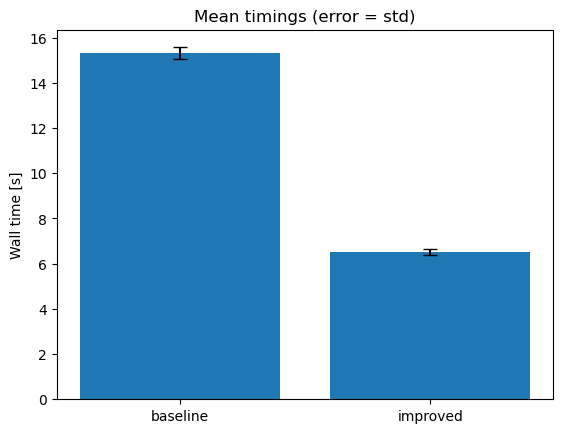

In [3]:

import matplotlib.pyplot as plt
import numpy as np

if (b_mean is not None) and (i_mean is not None):
    plt.figure()
    x = np.arange(2)
    means = [b_mean, i_mean]
    errs  = [b_std or 0.0, i_std or 0.0]
    plt.bar(x, means, yerr=errs, capsize=5)
    plt.xticks(x, labels)
    plt.ylabel("Wall time [s]")
    plt.title("Mean timings (error = std)")
    plt.show()
else:
    print("No mean/std available from summary; skipping bar chart.")


## 4) Per-run timings & % time reduction

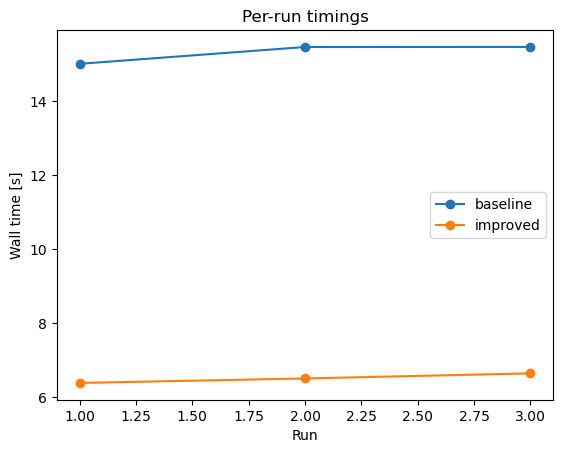

/tmp/hpcp44/ipykernel_1738840/2228824509.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([speedup_pct], labels=["% reduction"])


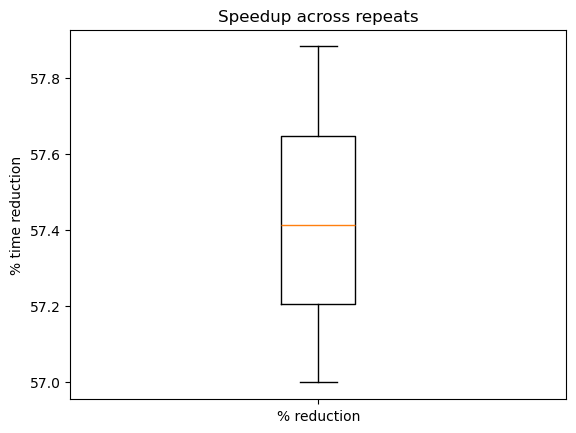

Speedup % per run: [57.41305494 57.8838949  56.99910006]
Mean: 57.432016631412544 Std: 0.44270208518959936


In [4]:

import numpy as np
import matplotlib.pyplot as plt

if elapsed_A_vec is not None and elapsed_B_vec is not None:
    runs = np.arange(1, len(elapsed_A_vec)+1)
    # Scatter
    plt.figure()
    plt.plot(runs, elapsed_A_vec, marker="o", label=labels[0])
    plt.plot(runs, elapsed_B_vec, marker="o", label=labels[1])
    plt.xlabel("Run"); plt.ylabel("Wall time [s]"); plt.title("Per-run timings"); plt.legend(); plt.show()

    # % time reduction
    speedup_pct = 100.0 * (1.0 - (elapsed_B_vec / elapsed_A_vec))
    plt.figure()
    plt.boxplot([speedup_pct], labels=["% reduction"])
    plt.ylabel("% time reduction"); plt.title("Speedup across repeats"); plt.show()

    print("Speedup % per run:", speedup_pct)
    print("Mean:", float(speedup_pct.mean()), "Std:", float(speedup_pct.std(ddof=1)) if speedup_pct.size>1 else 0.0)
else:
    print("No per-run vectors available; skipping scatter and boxplot.")


## 5) χ² distributions (overlaid histograms)

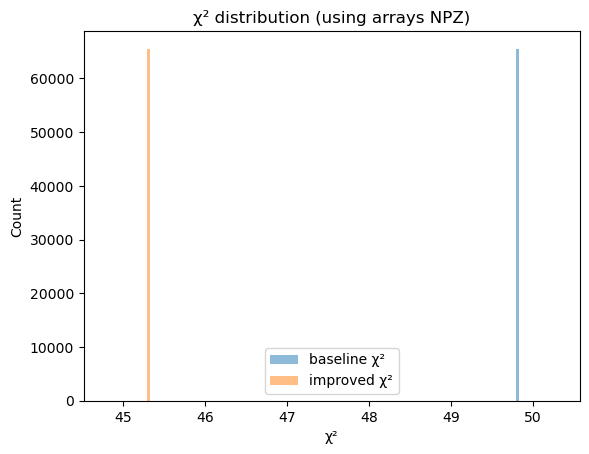

In [5]:

import numpy as np
import matplotlib.pyplot as plt

needed = all(k in arr.files for k in ["chisq_A","chisq_B"])
if needed:
    chisq_A = arr["chisq_A"].ravel()
    chisq_B = arr["chisq_B"].ravel()
    plt.figure()
    plt.hist(chisq_A, bins=30, alpha=0.5, label=f"{labels[0]} χ²")
    plt.hist(chisq_B, bins=30, alpha=0.5, label=f"{labels[1]} χ²")
    plt.xlabel("χ²"); plt.ylabel("Count"); plt.title("χ² distribution (using arrays NPZ)"); plt.legend(); plt.show()
else:
    print("chisq_A/chisq_B not found in arrays; skipping χ² hist.")


## 6) DEM(T) overlay (median over pixels)

ValueError: x and y can be no greater than 2D, but have shapes (256, 256, 34) and (256, 34)

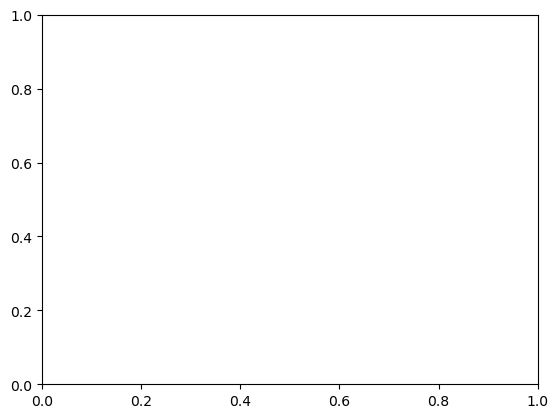

In [6]:

import numpy as np
import matplotlib.pyplot as plt

if all(k in arr.files for k in ["elogt_A","dem_A","dem_B"]):
    elogt = arr["elogt_A"]
    dem_A = arr["dem_A"]
    dem_B = arr["dem_B"]

    plt.figure()
    if dem_A.ndim == 1:
        plt.plot(elogt, dem_A, label=f"{labels[0]} DEM")
        plt.plot(elogt, dem_B, label=f"{labels[1]} DEM")
    else:
        # expect last axis = T
        nt = elogt.shape[0]
        A_stat = np.median(dem_A.reshape(-1, nt), axis=0) if dem_A.shape[-1]==nt else np.median(dem_A, axis=0)
        B_stat = np.median(dem_B.reshape(-1, nt), axis=0) if dem_B.shape[-1]==nt else np.median(dem_B, axis=0)
        plt.plot(elogt, A_stat, label=f"{labels[0]} (median)")
        plt.plot(elogt, B_stat, label=f"{labels[1]} (median)")
    plt.xlabel("log10 T [K]"); plt.ylabel("DEM (arb)"); plt.title("DEM overlay"); plt.legend(); plt.show()
else:
    print("elogt_A/dem_A/dem_B not found; skipping DEM overlay.")


## 7) ΔDEM median curve (Improved - Baseline)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

if all(k in arr.files for k in ["elogt_A","dem_A","dem_B"]):
    elogt = arr["elogt_A"]
    dem_A = arr["dem_A"]
    dem_B = arr["dem_B"]
    if dem_A.ndim == 1:
        delta = dem_B - dem_A
    else:
        nt = elogt.shape[0]
        A_med = np.median(dem_A.reshape(-1, nt), axis=0) if dem_A.shape[-1]==nt else np.median(dem_A, axis=0)
        B_med = np.median(dem_B.reshape(-1, nt), axis=0) if dem_B.shape[-1]==nt else np.median(dem_B, axis=0)
        delta = B_med - A_med
    plt.figure()
    plt.plot(elogt, delta)
    plt.xlabel("log10 T [K]"); plt.ylabel("ΔDEM (Improved - Baseline)"); plt.title("DEM median difference"); plt.show()
else:
    print("Missing arrays for ΔDEM; skipping.")
